In [1]:
import os
import gradio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image,ImageChops

In [2]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()

        # Encoder
        self.input_to_hidden = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_to_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.hidden_to_log_var = torch.nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.latent_to_hidden = torch.nn.Linear(latent_dim, hidden_dim)
        self.hidden_to_output = torch.nn.Linear(hidden_dim, input_dim)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def Encoder(self, x):
        h = self.input_to_hidden(x)
        mu = self.hidden_to_mu(h)
        log_var = self.hidden_to_log_var(h)
        return mu, log_var

    def Decoder(self, z):
        h = self.latent_to_hidden(z)
        x_hat = torch.sigmoid(self.hidden_to_output(h))
        return x_hat

    def forward(self, X):
        mu, log_var = self.Encoder(X)
        z = self.reparameterize(mu, log_var)
        x_hat = self.Decoder(z)
        return x_hat, mu, log_var

    def loss_function(self, X, x_hat, mu, log_var):
        BCE = torch.nn.functional.mse_loss(x_hat, X, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var))
        return BCE + KLD

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def accuracy(self, X, x_hat):
        X = torchvision.transforms.functional.to_pil_image(X)
        x_hat = torchvision.transforms.functional.to_pil_image(x_hat)
        diff = ImageChops.difference(X, x_hat)
        rms = diff.rms  # Calculate RMS value
        return rms

    def Train(self, X, epochs=100):
        history = []
        x_hat = None
        self.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            x_hat, mean, log_var = self.forward(X)
            loss = self.loss_function(X, x_hat, mean, log_var)
            loss.backward()
            self.optimizer.step()
            print(f'Epoch: {epoch}, Loss: {loss.item()}')
            history.append(loss.item())

        plt.plot(history)
        return history, x_hat

In [3]:
# mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(mnist, shuffle=True, batch_size=mnist.train_data.shape[0])
# image, label = next(iter(train_loader))

In [4]:
Transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((800, 800)),
    torchvision.transforms.ToPILImage(mode='RGB')
])

In [5]:
# dataFromLocal = torchvision.datasets.ImageFolder(root='./data/toys_dataset/images', transform=Transform)
# dataLoader = torch.utils.data.DataLoader(dataFromLocal, shuffle=True, batch_size=300)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './data/toys_dataset/images'

In [ ]:
# dataLoader.dataset[-1][0]

In [7]:
images_panda = np.zeros((105, 3 * 100 * 100))
images_rabbit = np.zeros((150, 3 * 100 * 100))
for i, img in enumerate(os.listdir('../toys_dataset/images/Panda')):
    im = Image.open('../toys_dataset/images/Panda/' + img)
    im = im.resize((100, 100))
    images_panda[i] = np.array(im).reshape(3 * 100 * 100)
for i, img in enumerate(os.listdir('../toys_dataset/images/Rabbit')):
    im = Image.open('../toys_dataset/images/Rabbit/' + img)
    im = im.resize((100, 100))
    images_rabbit[i] = np.array(im).reshape(3 * 100 * 100)
images_panda = images_panda / 255.
images_rabbit = images_rabbit / 255.

In [8]:
images_panda.shape, images_rabbit.shape

((105, 30000), (150, 30000))

In [9]:
images = np.concatenate((images_panda, images_rabbit))

In [10]:
images = torch.from_numpy(images)

In [11]:
images = images.to(torch.float32)

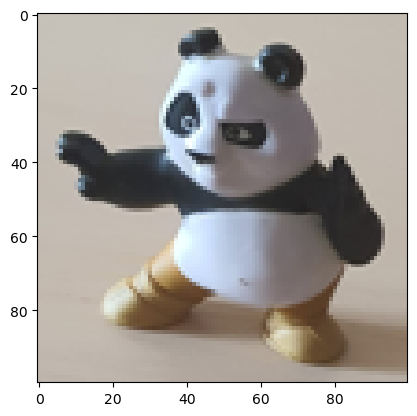

In [12]:
plt.imshow(images[0].reshape(100, 100, 3))

In [ ]:
model = VAE(input_dim=30000, latent_dim=20, hidden_dim=300)

In [ ]:
model

In [ ]:
torch.cuda.is_available()

In [ ]:
_, x_reconstructed = model.Train(images, epochs=1000)

In [ ]:
x_reconstructed.shape

In [ ]:
x_reconstructed[0].shape

In [ ]:
plt.imshow(x_reconstructed[0].detach().numpy().reshape(100, 100, 3))

In [ ]:

import matplotlib.pyplot as plt


def plotting(num_images=10):
    plt.figure(figsize=(20, 20))
    f = plt.gcf()
    for i in range(num_images):
        # display original
        ax = plt.subplot(10, 2, 2 * i + 1)
        plt.imshow(images[i].reshape(100, 100, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(10, 2, 2 * i + 2)
        plt.imshow(x_reconstructed[i].detach().numpy().reshape(100, 100, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig = plt.gcf()
    fig.savefig('Reconstructed.jpeg')
    created_image = Image.open('Reconstructed.jpeg')
    plt.show()
    return created_image

In [ ]:
created_image = plotting(2)

In [ ]:
interface = gradio.Interface(
    plotting,
    gradio.Slider(1, 10, label="Choose number images", step=1),
    gradio.Image(label="Reconstructed Images", show_label=True)
)

In [ ]:
interface.launch()